In [18]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

import torch.nn.functional as F

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../sympdee/sympde/viz'))
sys.path.append(os.path.join(os.getcwd(), '..'))

from symlie.model.networks.linear import CalculatedP, LinearP
from sympdee.sympde.viz.general_plots import imshows, plot_vals, simple_imshow, savefig, simple_imshow, imshow
from symlie.misc.utils_results import get_and_check_Ps, plot_seeds_and_Ps
from symlie.data.transforms import Transform
from symlie.model.networks.implicit import LinearImplicit
from symlie.model.setup import load_implicitP_statedict, load_P_pred
from symlie.model.loss import mmd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def plot_2columns(x_plots, x_titles):

    nrows = len(x_plots)
    batch_size = x_plots[0][0].shape[0]

    x_idx = np.random.randint(0, batch_size, 1)[0]
    fig, axs = plt.subplots(nrows, 2, figsize = (6, 1.*nrows), tight_layout = True)
    for i, (x_l, x_r) in enumerate(x_plots):

        for j, (x_lr, color) in enumerate(zip([x_l, x_r], ['tab:blue', 'tab:orange'])):
            xx = x_lr[x_idx]
            ax = axs[i, j]
            ax.plot(xx, 'o-', color = color)
            ax.plot([len(xx)-1, len(xx)], [xx[-1], xx[0]], '--', color=color)
            ax.plot([-1, 0], [xx[-1], xx[0]], '--', color=color)
            ax.set_xticks([])
            ax.set_yticks([0])
            ax.set_title(x_titles[i][j])
    plt.show()

def mmd_loss(x, y, kernel = 'multiscale'):
    x, y = x.reshape(-1, 1), y.reshape(-1, 1)
    return mmd(x, y, kernel = kernel)

In [20]:
map_kwargs = {
    'data_kwargs': {'grid_size': (1, 7), 'noise_std': 0.5},
    'transform_kwargs': {'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip': False},
    'data_dir': '../data/sine1d'
}

batch_size = 16

size = np.prod(map_kwargs['data_kwargs']['grid_size'])
features = size**2
set_bias = False

In [21]:
x = torch.randn(batch_size, size)

def transform(x):
    return torch.roll(x, 1, 1)

In [23]:


# # P = torch.zeros(features, features)

# P = load_P_pred('40avqgiy')
# P = load_P_pred('temp_runid')

# # P = get_and_check_Ps([1], map_kwargs, use_P_from_noise = True)[0]
# P = 'space_translation'
# P = 'none'

linear_kwargs = {
    'in_features': size,
    'out_features': size,
    'bias': set_bias,
    'train_P': True,
    'train_weights': False
}

batch_size_forward = None
# batch_size_forward = batch_size

# linear = LinearP(P_init = P, **linear_kwargs)
# linear_none = LinearP(P_init = 'none', **linear_kwargs)
# linear.reset_parameters(batch_size=batch_size_forward)
# linear_none.reset_parameters(batch_size=batch_size)
# linear_none.weight = linear.weight

# imshow(linear.P.detach(), l = 0.5)


P_init_statedict = load_implicitP_statedict('temp_runid')
linear = LinearImplicit(P_init = P_init_statedict, hidden_implicit_layers = [49, 49], **linear_kwargs)
linear.reset_parameters()

# linear_none = LinearP(P_init = 'none', **linear_kwargs)
# linear_none.reset_parameters(batch_size=batch_size)
# linear_none.weight = linear.weight

Setup implicit_P
Loading weights P


In [24]:
x_a = x
out_a = linear(x_a, batch_size=batch_size_forward).detach()
out_a_prime = transform(out_a)

# out_a_tilde = linear_none(x_a, batch_size=batch_size_implicit).detach()
# out_a_prime_tilde = transform(out_a_tilde)

x_b = x
x_b_prime = transform(x_b)
out_b_prime = linear(x_b_prime, batch_size=batch_size_forward).detach()

# out_b_prime_tilde = linear_none(x_b_prime, batch_size=batch_size_implicit).detach()

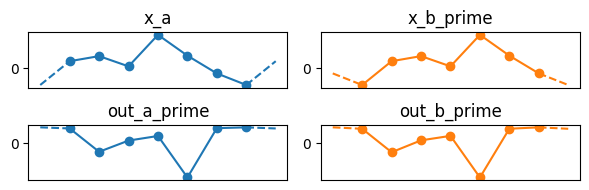

In [25]:
x_plots = [
    [x_a, x_b_prime],
    [out_a_prime, out_b_prime],
]

x_titles = [
    ['x_a', 'x_b_prime'],
    ['out_a_prime', 'out_b_prime'],
]


plot_2columns(x_plots, x_titles)


In [38]:
linear.reset_parameters()
linear.weight

tensor([[ 0.6147, -1.2229, -0.7447, -0.2779,  1.0218, -0.6097, -0.1183],
        [ 0.4390,  0.6830,  0.4082, -1.8041,  2.1090,  1.5469,  0.2619],
        [-0.1225,  0.0042,  0.2927,  0.1673, -0.5700, -1.1473, -0.0600],
        [ 0.3560, -0.5399,  1.6128, -3.2530,  0.9459,  1.2117,  0.5262],
        [-0.0246, -0.9863, -0.2245, -0.6823,  0.5604, -1.9532,  0.8229],
        [ 0.2843,  1.0303, -2.1452, -0.0532, -2.1416, -0.7275,  0.4663],
        [ 0.3883, -0.2614, -0.2373,  1.3300, -0.4542, -0.3261,  1.2037]])

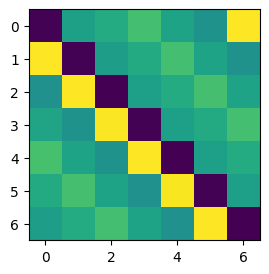

In [35]:
plt.figure(figsize=(3,3))
linear.reset_parameters()
plt.imshow( linear(x, batch_size=batch_size_forward, return_weight=True).detach().cpu().numpy() )
plt.show()

In [168]:
((out_a_prime - out_b_prime)**2).mean()

tensor(0.1139)

In [130]:
weight = linear.weight.data
implicitP = linear.implicit_P

weight2 = implicitP(weight.flatten()).reshape(weight.shape)

weight2

tensor([[-1.5783,  0.5367,  0.4917, -0.1204,  0.1175,  0.3228,  1.3046],
        [ 1.3050, -1.5713,  0.5411,  0.4922, -0.1219,  0.1167,  0.3259],
        [ 0.3151,  1.2995, -1.5742,  0.5434,  0.4949, -0.1174,  0.1169],
        [ 0.1168,  0.3132,  1.3067, -1.5752,  0.5388,  0.5013, -0.1168],
        [-0.1209,  0.1188,  0.3199,  1.3062, -1.5741,  0.5418,  0.4916],
        [ 0.4892, -0.1171,  0.1190,  0.3251,  1.2935, -1.5726,  0.5470],
        [ 0.5446,  0.4917, -0.1208,  0.1211,  0.3193,  1.2960, -1.5712]],
       grad_fn=<ViewBackward0>)

In [13]:
# def network_simple_plot(x, savename, subdir, color, l = 1.):
#     x = x[0]
#     fig, ax = plt.subplots(1, 1, figsize = np.array([3, 1])*l, tight_layout = True)
#     ax.plot(x, color = color, marker = 'o')
#     ax.axis('off')
#     # plt.show()
#     # return
#     savefig(fig, savename, subdir = subdir)
#     plt.close()

# print('tilde')
# save_plots = [(x, 'x'), (x_b_prime, 'x_b_prime'), (out_a, 'o_a'), (out_a_prime, 'o_a_prime'), (out_b_prime, 'o_b_prime'), (out_a_tilde, 'o_a_tilde'), (out_a_prime_tilde, 'o_a_prime_tilde'), (out_b_prime_tilde, 'o_b_prime_tilde')]
# for save_fig, save_name in save_plots:
#     if 'x' in save_name:
#         color = 'tab:blue'
#     elif 'o' in save_name:
#         color = 'tab:red'
#     else:
#         raise ValueError

    
#     network_simple_plot(save_fig, save_name, subdir = os.path.join('stepa', 'tilde'), color = color)

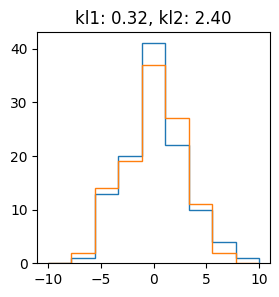

In [70]:
l = 10
n_bins = 10
bins = np.linspace(-l, l, n_bins)

def hist(x, bins_n = len(bins)-1, bins_min = bins.min(), bins_max = bins.max(), eps = 1e-9):
    return torch.histc(x, bins = bins_n, min = bins_min, max = bins_max) + eps

def kl(p, q, make_hist = True, reduction = 'batchmean'):
    if make_hist:
        p = hist(p)
        q = hist(q)
    return F.kl_div(p.log(), q, reduction=reduction)

plt.figure(figsize = (3,3))
plt.stairs(hist(out_a_prime), bins, color = 'tab:blue')
plt.stairs(hist(out_a_prime_tilde), bins, color = 'tab:orange')
kl1, kl2 = kl(out_a_prime, out_a_prime_tilde), kl(out_a_prime_tilde, out_a_prime)
plt.title(f'kl1: {kl1:.2f}, kl2: {kl2:.2f}')
plt.show()


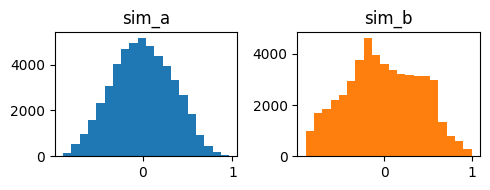

In [ ]:
def similarity(a, b):
    return F.cosine_similarity(a, b, dim = 1)
    # return F.kl_div(torch.exp(a), torch.exp(b), reduction='none')

# sim_a = similarity(out_a_prime, out_a_prime_tilde)
# sim_b = similarity(out_b_prime, out_b_prime_tilde)

sim_x = similarity(x_a, x_b_prime)
sim_o = similarity(out_a, out_b_prime)

# plot2(sim_a, sim_b, 'sim_a, sim_b')

sim_a, sim_b = sim_x, sim_o

# plot two histograms next to each other
fig, axs = plt.subplots(1, 2, figsize = (5, 2), tight_layout = True)
axs[0].hist(sim_a.numpy(), bins = 20, color = 'tab:blue')
axs[0].set_title('sim_a')

axs[1].hist(sim_b.numpy(), bins = 20, color = 'tab:orange')
axs[1].set_title('sim_b')

plt.show()

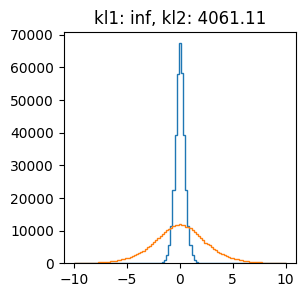

In [ ]:
kl(out_a_prime, out_a_prime_tilde)

tensor(0.2117)

In [ ]:
hist(out_a_prime)

tensor([   33.,    50.,    58.,    67.,    78.,    99.,   113.,   139.,   152.,
          180.,   199.,   250.,   314.,   278.,   389.,   419.,   501.,   547.,
          697.,   770.,   916.,   934.,  1125.,  1364.,  1490.,  1666.,  2035.,
         2129.,  2565.,  2890.,  3206.,  3608.,  3891.,  4230.,  4900.,  5343.,
         5993.,  6579.,  7267.,  7634.,  8302.,  8983.,  9549., 10133., 10837.,
        11039., 11384., 11813., 11777., 12131., 11671., 11845., 11510., 11163.,
        10646., 10053.,  9582.,  8905.,  8358.,  7723.,  7225.,  6504.,  5807.,
         5267.,  4835.,  4458.,  3907.,  3448.,  3054.,  2798.,  2518.,  2187.,
         1961.,  1734.,  1524.,  1367.,  1116.,  1026.,   884.,   760.,   634.,
          607.,   506.,   429.,   377.,   339.,   263.,   245.,   208.,   192.,
          151.,   107.,   127.,    83.,    84.,    73.,    68.,    60.,    36.])

In [ ]:
F.kl_div(out_a_prime_hist.log(), out_a_tilde_hist, reduction='batchmean'), F.kl_div(out_a_hist.log(), out_a_tilde_hist, reduction='batchmean')

NameError: name 'out_a_prime_hist' is not defined

In [ ]:
bins = torch.linspace(-1, 1, 50)


x_a_hist, bin_edges = torch.histogram(x_a, bins = bins)
# x_b_prime_hist, _ = torch.histogram(x_b_prime, bins = bins)
x_a_hist

tensor([349., 355., 406., 422., 409., 471., 433., 441., 464., 525., 477., 507.,
        544., 478., 488., 512., 532., 591., 558., 608., 560., 551., 523., 546.,
        605., 570., 561., 598., 529., 526., 534., 538., 540., 543., 504., 522.,
        534., 492., 561., 519., 484., 481., 413., 436., 385., 410., 381., 350.,
        341.])

In [ ]:
torch.histc(x_a, bins = 50-1, min = -1, max = 1)

tensor([349., 355., 406., 422., 409., 471., 433., 441., 464., 525., 477., 507.,
        544., 478., 488., 512., 532., 591., 558., 608., 560., 551., 523., 546.,
        605., 570., 561., 598., 529., 526., 534., 538., 540., 543., 504., 522.,
        534., 492., 561., 519., 484., 481., 413., 436., 385., 410., 381., 350.,
        341.])

ValueError: x and y must have same first dimension, but have shapes torch.Size([50]) and torch.Size([49])

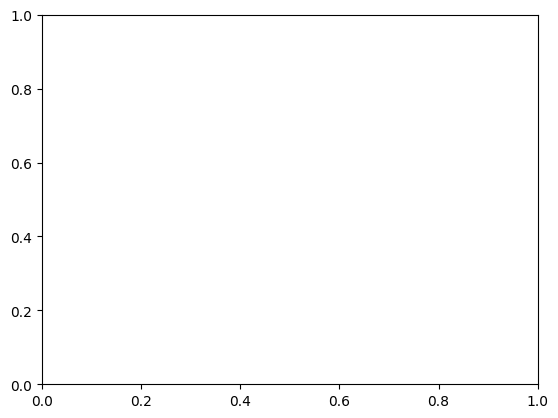

In [ ]:
plt.step(bin_edges, x_a_hist, color = 'tab:blue')